## Generating Traffic Image Data

In [ ]:
pip install Pillow

In [1]:
## Importing libraries
import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

## Housekeeping
training_image_dir = Path("Image_Data/Training/Filled")
training_image_missing_dir = Path("Image_Data/Training/Missing")
testing_image_dir = Path("Image_Data/Test5")

training_image_dir.mkdir(parents = True, exist_ok = True)
training_image_missing_dir.mkdir(parents = True, exist_ok = True)
testing_image_dir.mkdir(parents = True, exist_ok = True)

pd.set_option('display.max_columns', None, 'display.max_rows', None)

#### Generating Training Images

In [2]:
## Initializing traffic_data data-frame
traffic_data = pd.DataFrame()

## Concatenating each data file to traffic_data
for year in os.listdir('Traffic_Data/'):
    for file_name in os.listdir(os.path.join('Traffic_Data', year)):
        file = pd.read_csv(os.path.join('Traffic_Data', year, file_name))
        traffic_data = pd.concat([traffic_data, file], axis = 0)
        
## Changing 'Hour' variable to datetime and sorting by date
traffic_data['Hour'] = pd.to_datetime(traffic_data['Hour'])
traffic_data = traffic_data.sort_values('Hour').reset_index(drop = True)

## Reading California I-5 sensor information
all_sensors = pd.read_csv('Misc_Data/pems_sensors.csv'); all_sensors['ID'] = all_sensors['ID'].astype(str)

## Extracting columns from traffic_data data-frame
data_sensors = pd.DataFrame({'Sensor': traffic_data.drop(columns = ['Hour', '# Lane Points', '% Observed']).columns})
data_sensors['ID'] = data_sensors['Sensor'].str.split('-', n = 1, expand = True)[0].astype(str)

## Inner joining data-frames and sorting by ordering (S --> N, San Diego --> Oregon)
new_sensors = data_sensors.merge(all_sensors, how = 'inner', on = 'ID').sort_values('Ordering').reset_index(drop = True)

## Extracting proper column ordering and adding 'Hour' to the beginning
all_columns = new_sensors['Sensor'].tolist()
all_columns.insert(0, 'Hour')

## Changing column ordering of traffic_data
traffic_data = traffic_data[all_columns]

## Dropping all columns in traffic_data with missing values
traffic_data = traffic_data.dropna(axis = 'columns')

## Cutting some rows to make n_cols % 10 = 0
traffic_data = traffic_data.iloc[:, 0:461]

## Cutting some rows to make n_rows % 200 = 0
traffic_data = traffic_data.iloc[0:38400,]

## Saving 'Hour' variable
hour = traffic_data['Hour']

In [3]:
## Scaling the data to be between 0-254
traffic_data = traffic_data.drop(columns = ['Hour'])
flat_data = traffic_data.to_numpy().flatten().astype(int)
minimum = np.min(flat_data); maximum = np.max(flat_data)
n = traffic_data.shape[0]; p = traffic_data.shape[1]
flat_data = 254 * (flat_data - minimum) / (maximum - minimum)
scaled_data = pd.DataFrame(flat_data.reshape((n, p)), columns = traffic_data.columns)

## Defining function to randomly remove 10% of observations
def delete_10(col):
    col.loc[col.sample(frac = 0.1).index] = np.nan
    return col

## traffic_data - traffic data scaled to 0-254
traffic_data = scaled_data
pd.concat([hour, traffic_data], axis = 1).to_csv('Output_Data/traffic_data.csv', index = False)

## traffic_data_missing - 10% missing values
traffic_data_missing = scaled_data.apply(delete_10, axis = 0)
pd.concat([hour, traffic_data_missing], axis = 1).to_csv('Output_Data/traffic_data_missing.csv', index = False)

## traffic_data_mapped - all missing values mapped to 255
traffic_data_mapped = traffic_data_missing.fillna(value = 255)
pd.concat([hour, traffic_data_mapped], axis = 1).to_csv('Output_Data/traffic_data_mapped.csv', index = False)

In [4]:
## Function to store all images to disk
def store_many_disk(df, image_dir):
    
    ## Initializing list to store images
    images = list()

    ## Initializing data windows
    n_time_windows = 32
    n_sensor_windows = 16
    
    for i in range(0, n_time_windows):
        for j in range(0, n_sensor_windows):

            ## Setting time window
            time_loc = [(i * 200), (i * 200 + 200)]

            ## Setting sensor window
            sensor_loc = [(j * 10), (j * 10 + 200)]

            ## Creating img with window subset
            img = np.array(df.iloc[time_loc[0]:time_loc[1], sensor_loc[0]:sensor_loc[1]])

            ## Appending to lists
            images.append(img)
            
    print("Loaded traffic data:")
    print(f" - np.shape(images)     {np.shape(images)}")
    
    ## Saving images one by one
    for i, image in enumerate(images):
        storing = Image.fromarray(image)
        storing = storing.convert('L')
        storing.save(image_dir / f"{i}.png")


## Storing training images to disk
store_many_disk(traffic_data, training_image_dir)
store_many_disk(traffic_data_mapped, training_image_missing_dir)

Loaded traffic data:
 - np.shape(images)     (512, 200, 200)
Loaded traffic data:
 - np.shape(images)     (512, 200, 200)


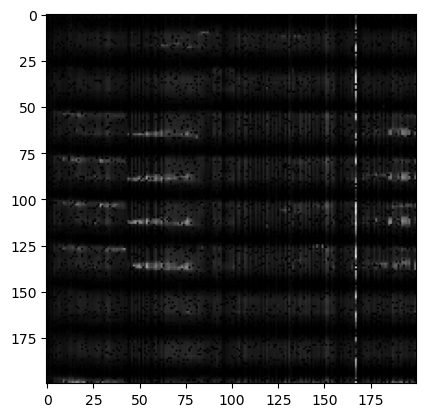

In [5]:
## Function to read n_images from disk
def read_many_disk(n_images):
    images = []
    for image_id in range(n_images):
        images.append(np.array(Image.open(training_image_dir / f"{image_id}.png")))
    return images

## Reading in a samplle image
n_images = 1
imgs = read_many_disk(n_images)

## Plotting an example training image
plt.imshow(imgs[0], cmap = 'gray')
plt.show()

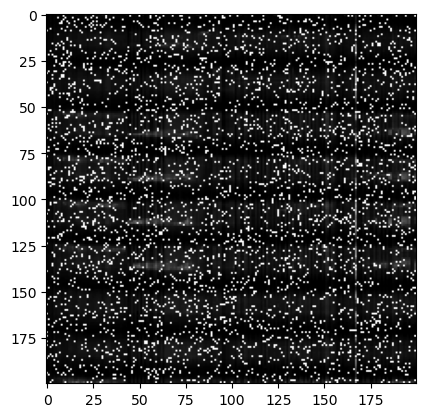

In [6]:
## Function to read n_images from disk
def read_many_disk(n_images):
    images = []
    for image_id in range(n_images):
        images.append(np.array(Image.open(training_image_missing_dir / f"{image_id}.png")))
    return images

## Reading in a samplle image
n_images = 1
imgs = read_many_disk(n_images)

## Plotting an example training image
plt.imshow(imgs[0], cmap = 'gray')
plt.show()

#### Generating Testing Images

In [ ]:
## Reading the data
jan = pd.read_csv('jan2023_output.csv')
feb = pd.read_csv('feb2023_output.csv')
mar = pd.read_csv('mar2023_output.csv')

## Concatenating all data
data = pd.concat([jan, feb, mar], axis = 0).drop(columns = ['Hour', '# Lane Points', '% Observed'])
data.reset_index(drop = True, inplace = True)

## Cutting some rows to make n_rows % 248 = 0
data = data.iloc[0:1736,]

## Scaling traffic values of data-frame to be between 0-255
flat_data = data.to_numpy().flatten()
flat_data = 255 * (flat_data - np.min(flat_data)) / (np.max(flat_data) - np.min(flat_data))
scaled_data = pd.DataFrame(flat_data.reshape((data.shape[0], data.shape[1])), columns = data.columns)

## Setting number of images to create
n_images = int(scaled_data.shape[0] / 248)

## Initializing list to store images
images = list()
labels = list()

## Creating n_images using the data
for i in range(n_images):
    img = np.array(scaled_data.iloc[(i * 248):(i*248)+248,])
    images.append(img)
    labels.append(0)
    
print("Loaded traffic data:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

In [ ]:
scaled_data.head()

In [ ]:
## Storing all images to disk
def store_many_disk(images, labels):

    ## Saving images one by one
    for i, image in enumerate(images):
        storing = Image.fromarray(image)
        storing = storing.convert('L')
        storing.save(disk_dir / f"{i}.png")
            
## Experimenting
store_many_disk(images, labels)

In [ ]:
## Reading all images from disk
def read_many_disk(n_images):
    images = []
    for image_id in range(n_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))
    return images

n_images = 7
imgs = read_many_disk(n_images)

In [ ]:
plt.imshow(imgs[0], cmap = 'gray')

### Experimenting with missing values:

In [ ]:
## Reading the data
jan = pd.read_csv('jan2023_output.csv')
feb = pd.read_csv('feb2023_output.csv')
mar = pd.read_csv('mar2023_output.csv')

## Concatenating all data
data = pd.concat([jan, feb, mar], axis = 0).drop(columns = ['Hour', '# Lane Points', '% Observed'])
data.reset_index(drop = True, inplace = True)

## Cutting some rows to make n_rows % 248 = 0
data = data.iloc[0:1736,]

## Scaling traffic values of data-frame to be between 0-255
flat_data = data.to_numpy().flatten()
flat_data = 255 * (flat_data - np.min(flat_data)) / (np.max(flat_data) - np.min(flat_data))
scaled_data = pd.DataFrame(flat_data.reshape((data.shape[0], data.shape[1])), columns = data.columns)

scaled_data.iloc[0:100, 0:30] = np.nan

## Setting number of images to create
n_images = int(scaled_data.shape[0] / 248)

## Initializing list to store images
images = list()
labels = list()

## Creating n_images using the data
for i in range(n_images):
    img = np.array(scaled_data.iloc[(i * 248):(i*248)+248,])
    images.append(img)
    labels.append(0)
    
print("Loaded traffic data:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

In [ ]:
scaled_data.head()

In [ ]:
## Storing all images to disk
def store_many_disk(images, labels):

    ## Saving images one by one
    for i, image in enumerate(images):
        storing = Image.fromarray(image)
        storing = storing.convert('L')
        storing.save(disk_dir / f"{i}.png")
            
## Experimenting
store_many_disk(images, labels)

In [ ]:
## Reading all images from disk
def read_many_disk(n_images):
    images = []
    for image_id in range(n_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))
    return images

n_images = 7
imgs = read_many_disk(n_images)

In [ ]:
plt.imshow(imgs[0], cmap = 'gray')

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
tf.data.Dataset??